In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import pandas as pd
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

### ルンゲクッタ法関連の参考
- https://kazmus.hatenablog.jp/entry/2017/03/02/204925
- https://qiita.com/TbsYS/items/b1c03c6d3d470287bd6b

In [2]:
@partial(jax.jit, static_argnums=0)
def solve_byRK(f, dt, tn, xn, u, seed):
    # 4次ルンゲクッタ法
    k1 = f(tn, xn, u, seed)
    k2 = f(tn+dt/2., xn+k1*dt/2., 0, seed)
    k3 = f(tn+dt/2., xn+k2*dt/2., 0, seed)
    k4 = f(tn+dt, xn+k3*dt, 0, seed)
    xn1 = xn + dt*(k1 + 2*k2 + 2*k3 + k4)/6.
    
    return xn1

batch_solve_byRK = jax.vmap(solve_byRK, in_axes=[None, None, None, -1, -1, -1], out_axes=-1) 

対象の系のダイナミクス
$$
\frac{d}{dt}
\begin{bmatrix}
x^{(1)} \\
x^{(2)} \\
\end{bmatrix}
= 
\begin{bmatrix}
-x^{(1)} + x^{(2)}\sin(x^{(2)}) \\
-x^{(1)}\sin(x^{(2)}) + u\\
\end{bmatrix}
+
\begin{bmatrix}
w^{(1)} \\
w^{(2)}\\
\end{bmatrix}
$$

$w^{(1)},~w^{(2)}$はそれぞれ$[-0.5, 0.5]$の一様分布から独立にドローされる

In [3]:
@jax.jit
def dyn(t, x, u, seed):
    tmp1 = -x[0] + x[1]*jnp.sin(x[1])
    tmp2 = -x[0]*jnp.sin(x[1]) + u
    tmp = jnp.array([tmp1, tmp2])
    rng = jax.random.PRNGKey(seed)
    tmp += jax.random.uniform(rng, [2,]) - 0.5
    return tmp

In [4]:
dt = 0.1
stop_time = 100
step_num = int(stop_time/dt) + 1 
ts = np.linspace(0, stop_time, step_num)
init_x = np.array([7., 9.])
seeds = np.random.randint(0, 255, step_num-1) #乱数固定

In [5]:
def get_unforced_response():
    xs = np.zeros((2,step_num))    
    xs[:,0] = init_x
    for k, t in enumerate(ts):    
        if k > 0:
            x = solve_byRK(dyn, dt, t, x, 0, seeds[k-1])
            xs[:, k] = x
        else:
            # 初期値
            x = jnp.array(init_x)
    return xs

In [6]:
xs = get_unforced_response()
df = pd.DataFrame()
df["Time"] = ts
df["x1"] = xs[0,:]
df["x2"] = xs[1,:]

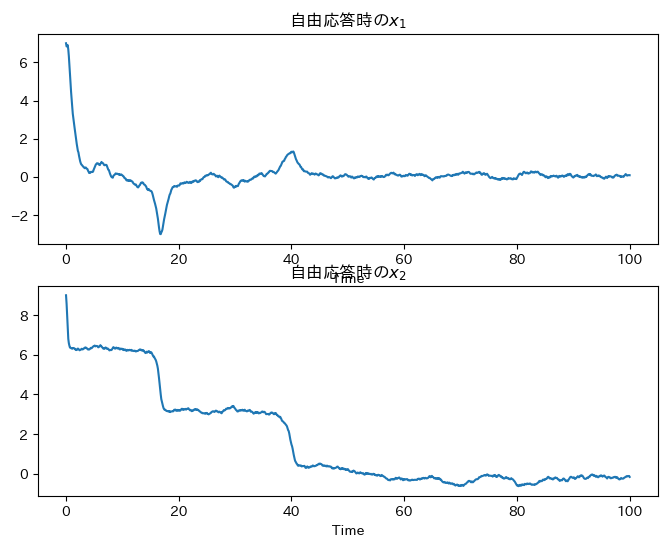

In [7]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
df.plot(ax = ax1, x = "Time", y = "x1", legend=False)
ax1.set_title("自由応答時の$x_1$")
df.plot(ax = ax2, x = "Time", y = "x2", legend=False)
ax2.set_title("自由応答時の$x_2$");

In [8]:
@jax.jit
def get_ivent_trigger(x, x_hat, L0, L1, L2):
    tmp = jnp.concat([x, x_hat])
    return tmp @ L2 @ tmp.T + L1.T @ tmp.T + L0
# batch_get_ivent_trigger = jax.vmap(get_ivent_trigger, in_axes=[-1, -1, None, None, None], out_axes=-1)

In [9]:
def get_response(K, L0, L1, L2, seeds):
    xs = np.zeros((2,step_num))
    trgs = np.zeros(step_num)
    xs[:,0] = init_x
    for k, t in enumerate(ts):    
        if k > 0:
            u = K @ x.T
            act_x = solve_byRK(dyn, dt, t, act_x, u, seeds[k-1])
            xs[:, k] = act_x
            iv_trg = get_ivent_trigger(act_x, x, L0, L1, L2)
            if iv_trg >= 0:
                x = jnp.copy(act_x)
                if k < step_num-1:
                    trgs[k+1] = 1
            
        else:
            # 初期値
            act_x = jnp.array(init_x)
            x = jnp.copy(act_x)
    return xs, trgs

In [10]:
K = jnp.array([0.0196, -0.837])
L0 = -1.6522
L1 = jnp.array([ -0.218, -0.0347, -0.5838, -0.3667])
L2 = jnp.array([[-0.0940, -0.2975, -0.8563, 0.3702],
                [-0.2975, 0.8026, 0.2669, -0.1481],
                [-0.8563, 0.2669, -0.7348, -0.0067],
                [0.3702, -0.1481, -0.0067, -0.3706]])

xs, trgs = get_response(K, L0, L1, L2, seeds)
df2 = pd.DataFrame()
df2["Time"] = ts
df2["x1"] = xs[0,:]
df2["x2"] = xs[1,:]

In [11]:
np.sum(trgs)

0.0

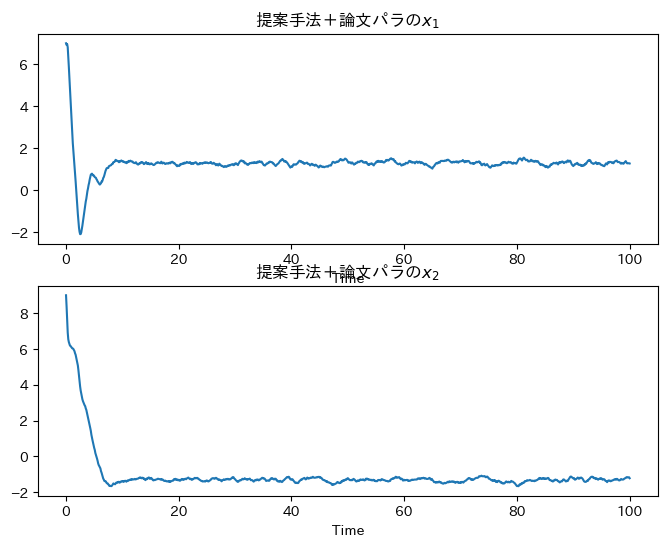

In [12]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
df2.plot(ax = ax1, x = "Time", y = "x1", legend=False)
ax1.set_title("提案手法＋論文パラの$x_1$")
df2.plot(ax = ax2, x = "Time", y = "x2", legend=False)
ax2.set_title("提案手法＋論文パラの$x_2$");

In [13]:
Q = jnp.eye(2)
Q_T = jnp.diag(jnp.array([10,10]))
R = 1
lam = 3

In [14]:
def gen_seed_batch(batch_size):
    return np.random.randint(0, 255, (step_num-1, batch_size))

In [15]:
init_K = jnp.array(np.random.randn(2))
init_L0 = jnp.array(np.random.randn(1))
init_L1 = jnp.array(np.random.randn(4))
init_L2 = jnp.array(np.random.randn(4,4)).reshape((-1,))
init_params = jnp.concat((init_K, init_L0, init_L1, init_L2))

In [16]:
def get_quad(x, A):
    return x @ A @x.T
batch_get_quad = jax.vmap(get_quad, in_axes=[-1, None], out_axes=-1)

def get_input(K, x):
    return K @ x.T
batch_get_input = jax.vmap(get_input, in_axes=[None, -1], out_axes=-1)
            
# def fb_control_and_calc_loss(batch_seed, params):
#     x_act = jnp.repeat(init_x[:, None], batch_size, axis=1)
#     x_hat = jnp.copy(x_act)
#     J = 0
#     for k, t in enumerate(ts):    
#         u = batch_get_input(params[:2], x_hat).reshape((1, batch_size))
#         J += jnp.sum(R * u * u)
#         print(x_act.shape, u.shape, batch_seed[k-1,:].reshape([1, batch_size]).shape)
#         x_act = batch_solve_byRK(dyn, dt, t, x_act, u, batch_seed[k-1,:].reshape([1, batch_size]))
#         J += jnp.sum(batch_get_dot(x_act, Q))
#         iv_trg = batch_get_ivent_trigger(x_act, x_hat, params[2], params[3:3+4], params[7:].reshape((4,4)))
#         J += lam * jnp.sum(jax.nn.sigmoid(iv_trg))
#         iv_trg = jnp.repeat(iv_trg[None, :], 2, axis=0)
#         x_hat =  iv_trg * x_act + (1- iv_trg) * x_hat

#     J -= jnp.sum(batch_get_dot(x_act, Q))
#     J += jnp.sum(batch_get_dot(x_act, Q_T))
#     return J/batch_size

def fb_control_and_calc_loss(seeds, max_itr, params):
    x_act = jnp.copy(init_x)
    x_hat = jnp.copy(x_act)
    J = 0
    for k in range(max_itr):
        u = get_input(params[:2], x_hat)
        J += R * u * u
        x_act = solve_byRK(dyn, dt, ts[k], x_act, u, seeds[k])
        
        J += get_quad(x_act, Q)
        iv_trg = get_ivent_trigger(x_act, x_hat, params[2], params[3:3+4], params[7:].reshape((4,4)))
        iv_trg = jax.nn.sigmoid(iv_trg)
        J += lam * iv_trg
        x_hat =  iv_trg * x_act + (1- iv_trg) * x_hat

    J -= get_quad(x_act, Q)
    J += get_quad(x_act, Q_T)
    return J/max_itr

In [17]:
adam_lr = 1e-6
train_num = 30
batch_size = 16
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(seeds, max_itr, step_num, opt_state):
    value, grads = jax.value_and_grad(fb_control_and_calc_loss, argnums=-1)(seeds, max_itr, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(params, batch_size):
    opt_state = opt_init(params)  
    for itr in trange(train_num, leave=False):
        batch_seeds = gen_seed_batch(batch_size)
        for i in range(batch_size):
            value, opt_state = step(batch_seeds[:, i], itr+10, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [18]:
trained_params = train(init_params, batch_size)

  0%|          | 0/30 [00:00<?, ?it/s]

loss:63.561832427978516 

In [22]:
K = trained_params[:2]
L0 = trained_params[2]
L1 = trained_params[3:3+4]
L2 = trained_params[7:].reshape((4,4))

xs, trgs = get_response(K, L0, L1, L2, seeds)
df3 = pd.DataFrame()
df3["Time"] = ts
df3["x1"] = xs[0,:]
df3["x2"] = xs[1,:]

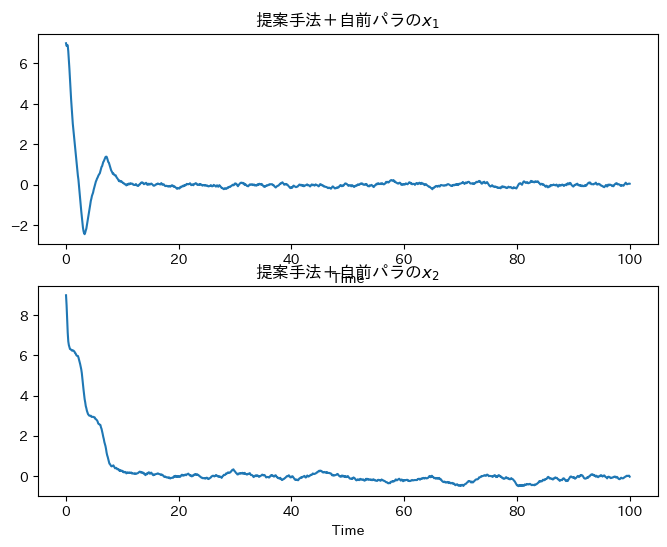

In [23]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
df3.plot(ax = ax1, x = "Time", y = "x1", legend=False)
ax1.set_title("提案手法＋自前パラの$x_1$")
df3.plot(ax = ax2, x = "Time", y = "x2", legend=False)
ax2.set_title("提案手法＋自前パラの$x_2$");

In [24]:
jnp.sum(trgs)

Array(983., dtype=float32)